# Mean-variance analysis with simulated data 


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
np.random.seed(123)

## Markowitz mean-variance analysis

Assume that we have $4$ assets, each with a return series of length $1000$. We can use numpy.random.randn to sample returns from a normal distribution (recall Class A).

In [3]:
## NUMBER OF ASSETS
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000

## VECTOR OF MEANS
mu_bar = np.array([0.,0.,0., 0.])
#mu_bar = np.array([0.001,0.002,0.005, 0.008])

## MATRIX OF COVARIANCE

#With this auxSigma matrix, inverting is stable
auxSigma = np.array ( [[1.,0.,0.,0.],[0,1,0,0],[0,0,1,0],[0,0,0,1]]) 

#With this auxSigma matrix, inverting is less stable
#auxSigma = np.array ( [[2,0.,0.,0.],[-0.2,0.7,0,0],[-0.3,0.4,0.7,0],[0.1,0.4,0.4,2.3]]) 

Sigma_exact =auxSigma.T@auxSigma
print (Sigma_exact)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [4]:
return_vec = np.random.multivariate_normal(mu_bar,Sigma_exact,n_obs)
print (return_vec.shape)

(1000, 4)


Text(0, 0.5, 'Returns')

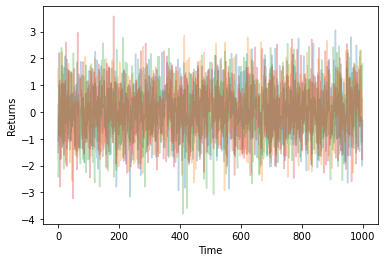

In [4]:
plt.plot(return_vec, alpha=0.3);
plt.xlabel('Time')
plt.ylabel('Returns')

### Random portfolios

Let's generate a couple of random portfolios. Let's assume for the moment that we restrict ourselves to have "long-only" portfolios, that is, the weights are nonnegative.

In [10]:
def rand_weights_pos(n):
    k = np.random.rand(n)
    return k / sum(k)

print(rand_weights_pos(n_assets))
print(rand_weights_pos(n_assets))

[0.08967598 0.28359082 0.34480736 0.28192584]
[0.25492346 0.29489952 0.16554644 0.28463058]


Let's next compute the expected return and standard deviation for a portfolio.

In [15]:
def random_portfolio(returns, weights):
    if returns.shape[1] != weights.shape[0]:
        print("Error: MSG by random_portfolio: dimensions don't fit")
        return 0

    w = np.asmatrix(weights)
    p = np.asmatrix(np.mean(returns, axis=0))
    C = np.asmatrix(np.cov(returns.T))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    return mu, sigma

Now, let's plot several such random risk-return profiles:

Text(0.5, 1.0, 'Mean and standard deviation of returns of randomly generated portfolios (long-only)')

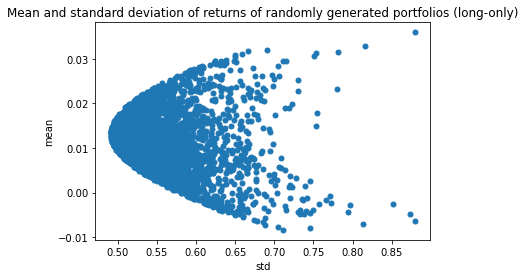

In [16]:
n_portfolios = 3000
means, stds = np.column_stack([random_portfolio(return_vec, rand_weights_pos(n_assets)) 
                               for _ in range(n_portfolios)])
plt.plot(stds, means,'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios (long-only)')

Text(0.5, 1.0, 'Mean and standard deviation of returns of randomly generated portfolios')

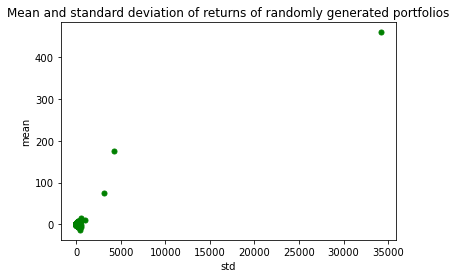

In [17]:
def rand_weights_unconstrained(n):
    k = np.random.rand(n)*2-1      # Uniformly distributed on [-1,1]
    return k / sum(k)

means_unc, stds_unc = np.column_stack([random_portfolio(return_vec, 
                        rand_weights_unconstrained(n_assets)) for _ in range(2 * n_portfolios)])
plt.plot(stds_unc, means_unc, 'og', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

Text(0.5, 1.0, 'Mean and standard deviation of returns of randomly generated portfolios')

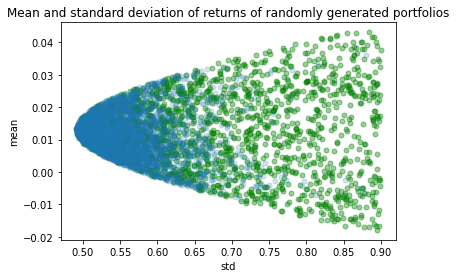

In [18]:
plt.plot(stds_unc[stds_unc<0.9], means_unc[stds_unc<0.9], 'og', 
         markersize=5, alpha=0.4)
plt.plot(stds, means, 'o', markersize=5, alpha=0.2)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

Let us now check the covariance matrix and find its inverse.

In [19]:
Sigma = np.cov(return_vec.T)
print(Sigma)

[[ 0.95457653  0.00415482  0.04630785 -0.03329693]
 [ 0.00415482  0.94767103  0.00220586 -0.0675899 ]
 [ 0.04630785  0.00220586  1.02460895  0.06388503]
 [-0.03329693 -0.0675899   0.06388503  0.94171693]]


Let us check the stability of the matrix with the condioned number

In [12]:
np.linalg.cond(Sigma)

1.2640656181430805

This is not too bad. We could move on without expecting major stability problems.

In [13]:
Sigma_inv = np.linalg.inv(Sigma)

### Markowitz, as done in the lecture notes

In [20]:
def Markowitz_weights(Sigma, mean_returns, mu_p):
    S_inv = np.linalg.inv(Sigma)
    pi_mu = S_inv @ (mean_returns)/sum(S_inv @ mean_returns)
    pi_1 = np.sum(S_inv, axis = 1) / sum(np.sum(S_inv, axis = 1) )
    lambda_demoninator = (mean_returns @ pi_mu) - (mean_returns@pi_1)
    ll = np.array((mu_p - (mean_returns @ pi_1))/lambda_demoninator)
    # previous line: to convert into array in case that mu_p is a single number
    ll.shape=(ll.size,1)
    return pi_mu * ll + pi_1 * (1-ll)

Remark: recall from the lecture that Markowitz needs at least two expected returns to differ. This is not the case via our simulated data. Indeed, any portfolio will have a zero expected return and the equally weighted portfolio will have the smallest variance. Let's just proceed, nevertheless, and see how far we get ... 

In [21]:
Sigma = np.cov(return_vec.T)
mean_returns = np.mean(return_vec, axis = 0)
Markowitz_weights(Sigma, mean_returns, 0.05)

array([[-0.14820352,  0.83623086, -0.24774642,  0.55971907]])

In [32]:
mu_p = np.arange(0.02,0.06,0.002)

In [33]:
Markowitz_weights(Sigma, mean_returns, mu_p)

array([[ 1.77270001e-01,  3.76150124e-01,  1.22801901e-01,
         3.23777975e-01],
       [ 1.55571766e-01,  4.06822173e-01,  9.80986790e-02,
         3.39507381e-01],
       [ 1.33873532e-01,  4.37494223e-01,  7.33954574e-02,
         3.55236788e-01],
       [ 1.12175297e-01,  4.68166272e-01,  4.86922358e-02,
         3.70966195e-01],
       [ 9.04770630e-02,  4.98838322e-01,  2.39890143e-02,
         3.86695601e-01],
       [ 6.87788285e-02,  5.29510371e-01, -7.14207263e-04,
         4.02425008e-01],
       [ 4.70805940e-02,  5.60182420e-01, -2.54174288e-02,
         4.18154415e-01],
       [ 2.53823595e-02,  5.90854470e-01, -5.01206504e-02,
         4.33883821e-01],
       [ 3.68412503e-03,  6.21526519e-01, -7.48238719e-02,
         4.49613228e-01],
       [-1.80141094e-02,  6.52198568e-01, -9.95270935e-02,
         4.65342635e-01],
       [-3.97123439e-02,  6.82870618e-01, -1.24230315e-01,
         4.81072041e-01],
       [-6.14105784e-02,  7.13542667e-01, -1.48933537e-01,
      

In [34]:
Mw1 = _

### Markowitz via an optimization algorithm

Next a different that also allows for additional constraints (e.g., nonnegative portfolio weights). 

In [26]:
from scipy.optimize import minimize

minimize?


In [27]:
def Markowitz_weights_opt(Sigma, mean_returns, mu_p, nonnegative = False, print_info = False):
    
    n = Sigma.shape[0]    
    mu_p_vect = np.array(mu_p)
    mu_p_vect.shape = (mu_p_vect.size,)
    # previous lines: to convert into array in case that mu_p is a single number
    portfolios = []
    x0 = np.ones(n)/n

    cost_fun = lambda x: (x@Sigma)@x
    
    for mu_p in mu_p_vect:        
        
        if nonnegative:
            cons = ({'type': 'eq', 'fun': lambda x: x@mean_returns - mu_p},
                    {'type': 'eq', 'fun': lambda x: x@np.ones(n) - 1},
                    {'type': 'ineq', 'fun': lambda x: x})

        else:
            cons = ({'type': 'eq', 'fun': lambda x: x@mean_returns - mu_p},
                    {'type': 'eq', 'fun': lambda x: x@np.ones(n) - 1})
                   
        # Calculate efficient frontier weights using quadratic programming
        res = minimize(cost_fun, x0, method = 'SLSQP', constraints=cons)
        if print_info:
            print(mu_p, res)
        portfolios.append(res.x)
    
    

    # Turning the portfolios into a numpy array
    portfolios = np.array([np.array(p).squeeze() for p in portfolios])
    
    return portfolios

In [22]:
Markowitz_weights_opt(Sigma, mean_returns, 0.012)

array([[0.26426984, 0.2540042 , 0.22165789, 0.26006807]])

In the following yet another implementation. Now, we are using the constraint $\mu^T \pi \geq \mu_p$ instead of $\mu^T \pi = \mu_p$.

In [38]:
def Markowitz_weights_optIneq(Sigma, mean_returns, mu_p_vect, nonnegative = False, print_info = False):
    
    n = Sigma.shape[0]    
    mu_p_vect = np.array(mu_p_vect)
    mu_p_vect.shape = (mu_p_vect.size,)
    # previous lines: to convert into array in case that mu_p is a single number
    portfolios = []
    x0 = np.ones(n)/n

    cost_fun = lambda x: (x@Sigma)@x
    
    for mu_p in mu_p_vect:        
        
        if nonnegative:
            cons = ({'type': 'ineq', 'fun': lambda x: x@mean_returns - mu_p},
                    {'type': 'eq', 'fun': lambda x: x@np.ones(n) - 1},
                    {'type': 'ineq', 'fun': lambda x: x})

        else:
            cons = ({'type': 'ineq', 'fun': lambda x: x@mean_returns - mu_p},
                    {'type': 'eq', 'fun': lambda x: x@np.ones(n) - 1})
                   
        # Calculate efficient frontier weights using quadratic programming
        res = minimize(cost_fun, x0, method = 'SLSQP', constraints=cons)
        if print_info:
            print(mu_p, res)
        portfolios.append(res.x)
        
    # Calculate efficient frontier weights using quadratic programming
    #portfolios = [opt.solvers.qp(S, opt.matrix(np.zeros(n)), G, h, A, opt.matrix([1.0,mu]))['x'] 
    #              for mu in mu_p]

    # Turning the portfolios into a numpy array
    portfolios = np.array([np.array(p).squeeze() for p in portfolios])
    
    return portfolios

In [36]:
Markowitz_weights_opt(Sigma, mean_returns, 0.02)

array([[0.17722274, 0.3761428 , 0.1228422 , 0.32379226]])

In [39]:
Markowitz_weights_optIneq(Sigma, mean_returns, 0.02)

array([[0.17722274, 0.3761428 , 0.1228422 , 0.32379226]])

In [40]:
Markowitz_weights_opt(Sigma, mean_returns, mu_p)

array([[ 1.77222742e-01,  3.76142799e-01,  1.22842201e-01,
         3.23792258e-01],
       [ 1.55524588e-01,  4.06812913e-01,  9.81380728e-02,
         3.39524426e-01],
       [ 1.33827209e-01,  4.37483230e-01,  7.34333192e-02,
         3.55256241e-01],
       [ 1.12175302e-01,  4.68166261e-01,  4.86922274e-02,
         3.70966210e-01],
       [ 9.04770885e-02,  4.98838268e-01,  2.39889674e-02,
         3.86695676e-01],
       [ 6.87788272e-02,  5.29510372e-01, -7.14205453e-04,
         4.02425006e-01],
       [ 4.70805919e-02,  5.60182422e-01, -2.54174260e-02,
         4.18154412e-01],
       [ 2.53823598e-02,  5.90854470e-01, -5.01206505e-02,
         4.33883821e-01],
       [ 3.68412504e-03,  6.21526519e-01, -7.48238718e-02,
         4.49613228e-01],
       [-1.80140075e-02,  6.52198440e-01, -9.95272426e-02,
         4.65342810e-01],
       [-3.97122055e-02,  6.82870458e-01, -1.24230511e-01,
         4.81072259e-01],
       [-6.14104308e-02,  7.13542513e-01, -1.48933739e-01,
      

In [41]:
Markowitz_weights_optIneq(Sigma, mean_returns, mu_p)

array([[ 1.77222743e-01,  3.76142797e-01,  1.22842199e-01,
         3.23792260e-01],
       [ 1.55524588e-01,  4.06812914e-01,  9.81380730e-02,
         3.39524426e-01],
       [ 1.33827211e-01,  4.37483228e-01,  7.34333163e-02,
         3.55256245e-01],
       [ 1.12175299e-01,  4.68166271e-01,  4.86922340e-02,
         3.70966197e-01],
       [ 9.04770662e-02,  4.98838316e-01,  2.39890087e-02,
         3.86695609e-01],
       [ 6.87788338e-02,  5.29510361e-01, -7.14216360e-04,
         4.02425021e-01],
       [ 4.70806255e-02,  5.60182369e-01, -2.54174802e-02,
         4.18154486e-01],
       [ 2.53823587e-02,  5.90854468e-01, -5.01206505e-02,
         4.33883824e-01],
       [ 3.68412457e-03,  6.21526519e-01, -7.48238711e-02,
         4.49613227e-01],
       [-1.80141115e-02,  6.52198569e-01, -9.95270909e-02,
         4.65342633e-01],
       [-3.97123461e-02,  6.82870616e-01, -1.24230313e-01,
         4.81072043e-01],
       [-6.14105597e-02,  7.13542643e-01, -1.48933564e-01,
      

In [42]:
Mw1

array([[ 1.77270001e-01,  3.76150124e-01,  1.22801901e-01,
         3.23777975e-01],
       [ 1.55571766e-01,  4.06822173e-01,  9.80986790e-02,
         3.39507381e-01],
       [ 1.33873532e-01,  4.37494223e-01,  7.33954574e-02,
         3.55236788e-01],
       [ 1.12175297e-01,  4.68166272e-01,  4.86922358e-02,
         3.70966195e-01],
       [ 9.04770630e-02,  4.98838322e-01,  2.39890143e-02,
         3.86695601e-01],
       [ 6.87788285e-02,  5.29510371e-01, -7.14207263e-04,
         4.02425008e-01],
       [ 4.70805940e-02,  5.60182420e-01, -2.54174288e-02,
         4.18154415e-01],
       [ 2.53823595e-02,  5.90854470e-01, -5.01206504e-02,
         4.33883821e-01],
       [ 3.68412503e-03,  6.21526519e-01, -7.48238719e-02,
         4.49613228e-01],
       [-1.80141094e-02,  6.52198568e-01, -9.95270935e-02,
         4.65342635e-01],
       [-3.97123439e-02,  6.82870618e-01, -1.24230315e-01,
         4.81072041e-01],
       [-6.14105784e-02,  7.13542667e-01, -1.48933537e-01,
      

All three methods therefore yield more or less the same portfolio, which is nice ...  (Markowitz_weights_optIneq only have an inequality constraint and yields results that have further away from the other two approaches).


(If we run again the problem with different means and variances the solution with inequality constraints drift further away. This is simply because those means cannot be attained using only positive portfolios).


In [43]:
portfolio_mu = [mean_returns @ x for x in Mw1]

In [44]:
portfolio_mu

[0.019999999999999997,
 0.021999999999999995,
 0.023999999999999994,
 0.026,
 0.02799999999999999,
 0.029999999999999992,
 0.03199999999999999,
 0.03399999999999999,
 0.03599999999999999,
 0.037999999999999985,
 0.03999999999999998,
 0.041999999999999975,
 0.043999999999999984,
 0.045999999999999985,
 0.04799999999999997,
 0.049999999999999975,
 0.05199999999999998,
 0.053999999999999986,
 0.055999999999999966,
 0.05799999999999997]

In [45]:
portfolio_sigma = [np.sqrt((x@Sigma)@x) for x in Mw1]

In [46]:
portfolio_sigma

[0.5155816324163689,
 0.5315419321289603,
 0.5509491496500153,
 0.5734534325916862,
 0.5987056431709378,
 0.6263735219026193,
 0.6561515561812542,
 0.6877657118379037,
 0.7209744919504026,
 0.755567664520399,
 0.7913637009977808,
 0.8282066486133914,
 0.8659628931544197,
 0.9045180737805883,
 0.9437742808709849,
 0.9836475866049637,
 1.0240659109629717,
 1.064967201054332,
 1.1062978905380776,
 1.1480116026673814]

Text(0.5, 1.0, 'Random portfolios and mean-variance frontier')

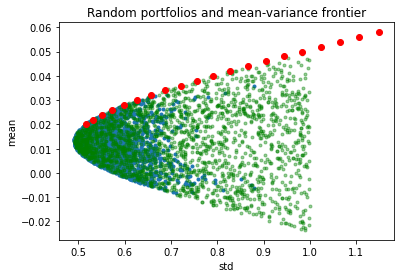

In [47]:
plt.plot(stds, means, 'o', markersize=3)
plt.plot(stds_unc[stds_unc<1], means_unc[stds_unc<1], 'og', 
         markersize=3, alpha=0.4)
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(portfolio_sigma, portfolio_mu, 'ro')
plt.title('Random portfolios and mean-variance frontier')

In [62]:
import numpy as np

import matplotlib.pyplot as plt

b1 = 1
b2 = 2

x1 = np.linspace(-3,0,100)
x2 = np.linspace(0,3,100)

y1 = b1/2 * np.exp(b1*x1)
y2 = b2/2 * np.exp(-b2*x1)
y = np.concatenate([y1,y2])


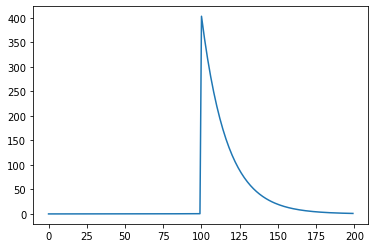

In [63]:
plt.plot(y)

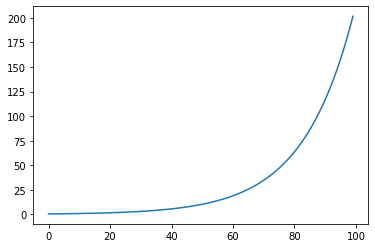

In [65]:
plt.plot(0.5*np.exp(b2*x2))

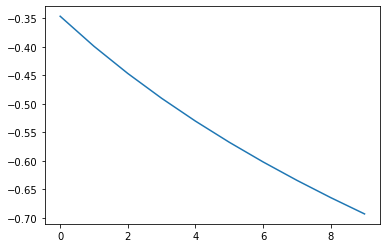

In [68]:
plt.plot(-(np.log(x) + np.log(2))/2)

In [166]:
np.random.binomial(1250, 0.01)

8